In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import wavefront as w
from examples import analytical_solutions as anso

### ***Propagation throught the rectangular aperture*** ###

Let us solve the direct problem of diffraction of a plane wave through a rectangular aperture in the Fresnel approximation

In [24]:
torch.set_default_dtype(torch.float64)
# screen size
lx = 40
ly = 40

# distance between the screen and the aperture, mm
z = 2000

# size of the aperture, mm
width = 4
height = 1

# wavelength, mm
lam = 1064 * 1e-6

# number of nodes
Nx = 3000
Ny = 3000

x_length = torch.linspace(-lx / 2, lx / 2, Nx)
y_length = torch.linspace(-ly / 2, ly / 2, Ny)

params = SimulationParameters(
    axes={
        'W': x_length,
        'H': y_length,
        'wavelength': lam
        })
xv, yv = params.meshgrid(x_axis='W', y_axis='H')

xv = xv.detach().numpy()
yv = yv.detach().numpy()

In [25]:
# create plane wave
incident_field = w.Wavefront.plane_wave(
    simulation_parameters=params,
    distance=0.,
    wave_direction=[0., 0., 1.]
)

# create square aperture
square = elements.RectangularAperture(
    simulation_parameters=params,
    width=width,
    height=height
)
aperture_shape = square.get_transmission_function()

# field after square aperture
transmission_field = square.forward(input_field=incident_field)

# field on the screen
output_field = elements.FreeSpace(
    simulation_parameters=params,
    distance=z,
    method='AS'
).forward(input_field=transmission_field)

# intensity distribution on the screen
intensity_output = output_field.intensity

rect = anso.RectangleFresnel(
    distance=z,
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    width=width,
    height=height,
    wavelength=lam
)

total_field = rect.field()

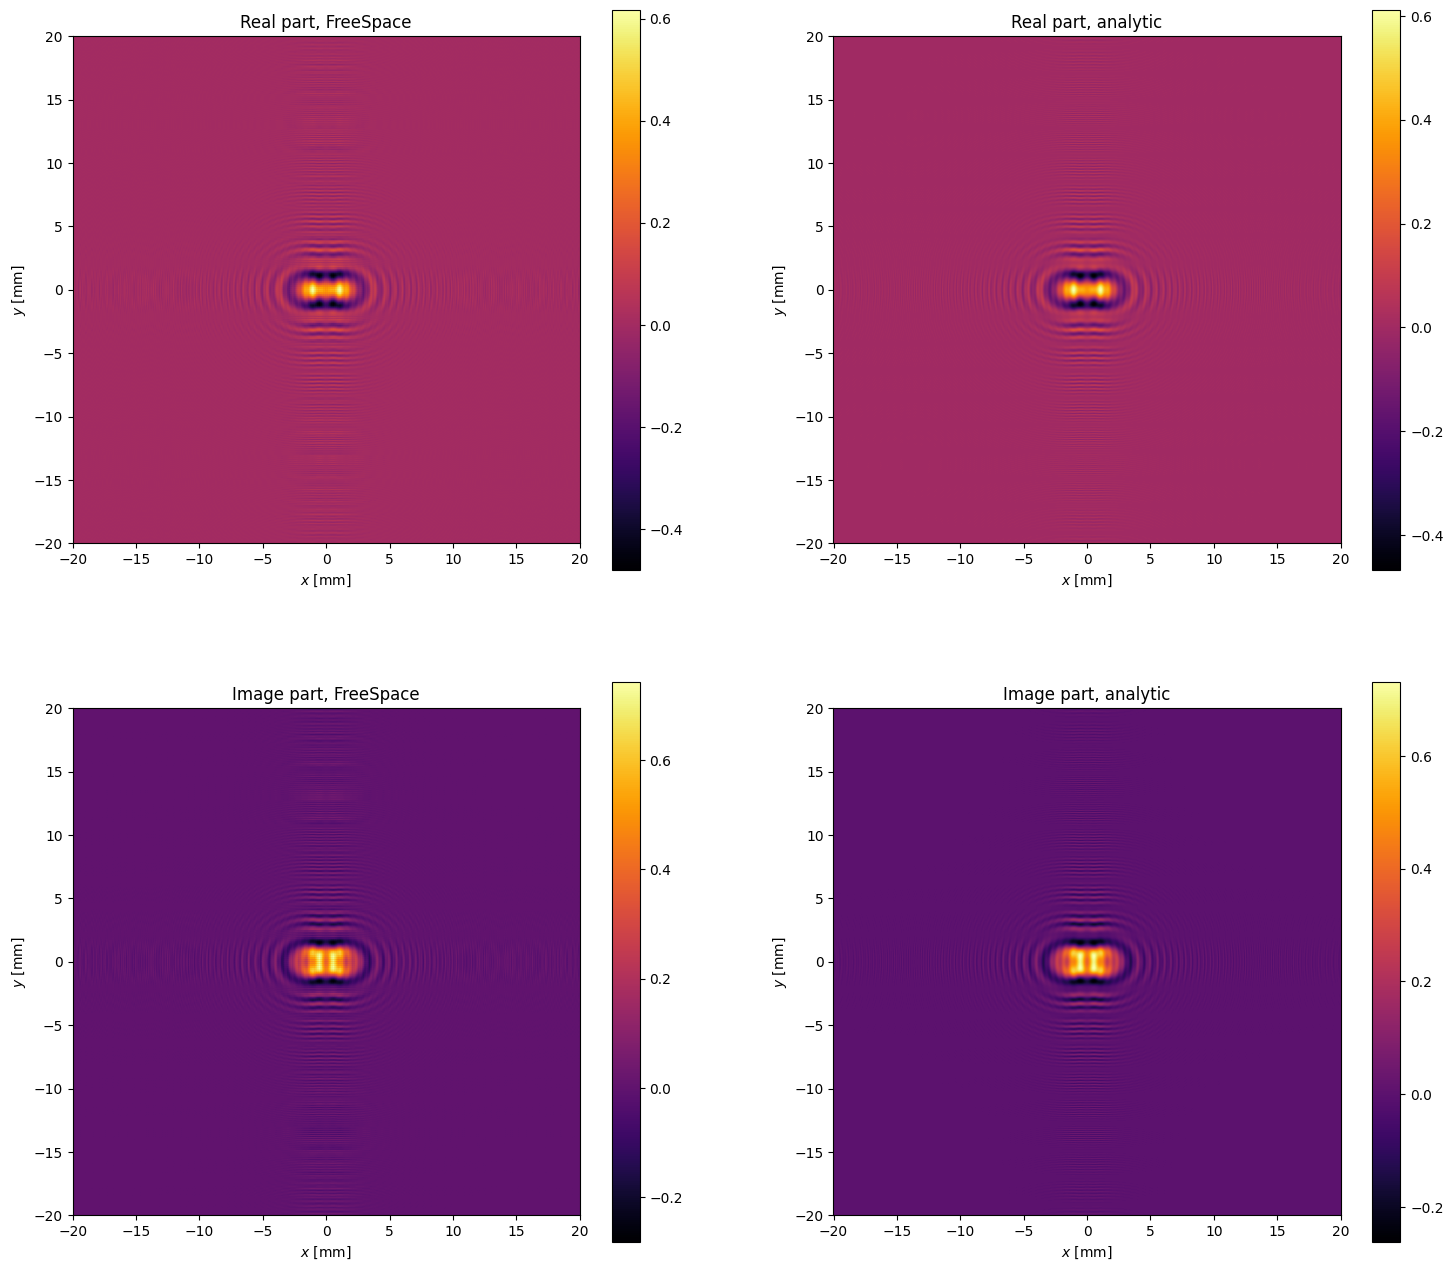

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 16))

im00 = ax[0, 0].pcolormesh(xv, yv, torch.real(output_field).detach().numpy(), cmap='inferno')
ax[0, 0].set_aspect('equal')
ax[0, 0].set_title(r'Real part, FreeSpace')
ax[0, 0].set_xlabel('$x$ [mm]')
ax[0, 0].set_ylabel('$y$ [mm]')
fig.colorbar(im00)

im01 = ax[0, 1].pcolormesh(xv, yv, np.real(total_field), cmap='inferno')
ax[0, 1].set_aspect('equal')
ax[0, 1].set_title(r'Real part, analytic')
ax[0, 1].set_xlabel('$x$ [mm]')
ax[0, 1].set_ylabel('$y$ [mm]')
fig.colorbar(im01)

im10 = ax[1, 0].pcolormesh(xv, yv, torch.imag(output_field).detach().numpy(), cmap='inferno')
ax[1, 0].set_aspect('equal')
ax[1, 0].set_title(r'Image part, FreeSpace')
ax[1, 0].set_xlabel('$x$ [mm]')
ax[1, 0].set_ylabel('$y$ [mm]')
fig.colorbar(im10)

im11 = ax[1, 1].pcolormesh(xv, yv, np.imag(total_field), cmap='inferno')
ax[1, 1].set_aspect('equal')
ax[1, 1].set_title(r'Image part, analytic')
ax[1, 1].set_xlabel('$x$ [mm]')
ax[1, 1].set_ylabel('$y$ [mm]')
fig.colorbar(im11)

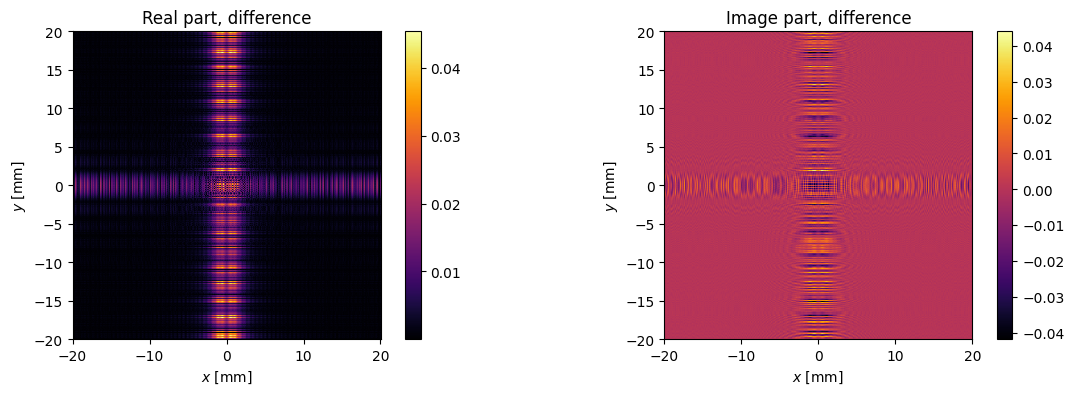

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

im1 = ax[0].pcolormesh(xv, yv, torch.abs(output_field - total_field).detach().numpy(), cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'Real part, difference')
ax[0].set_xlabel('$x$ [mm]')
ax[0].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(xv, yv, torch.imag(output_field - total_field).detach().numpy(), cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title(r'Image part, difference')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im2)

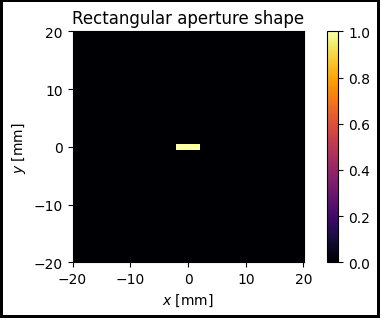

In [28]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(xv, yv, np.real(aperture_shape), cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Rectangular aperture shape')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

In [29]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(xv, yv, intensity_output.detach(), cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity profile on the screen')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

Error in callback <function _draw_all_if_interactive at 0x000001D5B5A819E0> (for post_execute), with arguments args (),kwargs {}:


MemoryError: Unable to allocate 275. MiB for an array with shape (3000, 3000, 4) and data type float64

MemoryError: Unable to allocate 275. MiB for an array with shape (3000, 3000, 4) and data type float64

<Figure size 600x300 with 2 Axes>

Let us compare the rigorous analytical solution of the problem of diffraction of a plane wave on a square aperture in the Fresnel approximation with the numerical one.

In [30]:
from tqdm import tqdm

nodes_array = torch.linspace(10, 5000, 10, dtype=torch.int)

error_list = []
energy_numeric_list = []
energy_analytic_list = []

length = 38.    # screen size, mm
distance = 500. # propagation distance, mm
width = 4   # width of the aperture, mm
height = 2  # height of the aperture, mm
lam = 1064 * 1e-6   # wavelength, mm

for n in tqdm(nodes_array):

    x_length = torch.linspace(-length / 2, length / 2, n)
    y_length = torch.linspace(-length / 2, length / 2, n)

    params = SimulationParameters(
        axes={
            'W': x_length,
            'H': y_length,
            'wavelength': lam
            })
    xv, yv = params.meshgrid(x_axis='W', y_axis='H')

    dx = length / n
    dy = length / n

    incident_field = w.Wavefront.plane_wave(
        simulation_parameters=params,
        distance=0.,
        wave_direction=[0., 0., 1.]
    )

    # field after square aperture
    transmission_field = elements.RectangularAperture(
        simulation_parameters=params,
        height=height,
        width=width
    ).forward(input_field=incident_field)

    # field on the screen
    output_field = elements.FreeSpace(
        simulation_parameters=params,
        distance=distance,
        method='fresnel'
    ).forward(input_field=transmission_field)

    # intensity on the screen
    intensity_output = output_field.intensity

    rect_int = anso.RectangleFresnel(
        distance=distance,
        x_size=length,
        y_size=length,
        x_nodes=n,
        y_nodes=n,
        width=width,
        height=height,
        wavelength=lam
    )

    intensity_analytic = torch.from_numpy(rect_int.intensity())

    intensity_difference = intensity_output - intensity_analytic
    energy_analytic = torch.sum(intensity_analytic).item() * dx * dy
    energy_numeric = torch.sum(intensity_output).item() * dx * dy

    error_list.append(torch.max(torch.abs(intensity_difference)).item())
    energy_analytic_list.append(energy_analytic)
    energy_numeric_list.append(energy_numeric)

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: bad operand type for abs(): 'method'

In [ ]:
error_list = np.array(error_list)
energy_numeric_list = np.array(energy_numeric_list)
energy_analytic_list = np.array(energy_analytic_list)
relative_error = np.abs((energy_analytic_list - energy_numeric_list)/ energy_analytic_list)

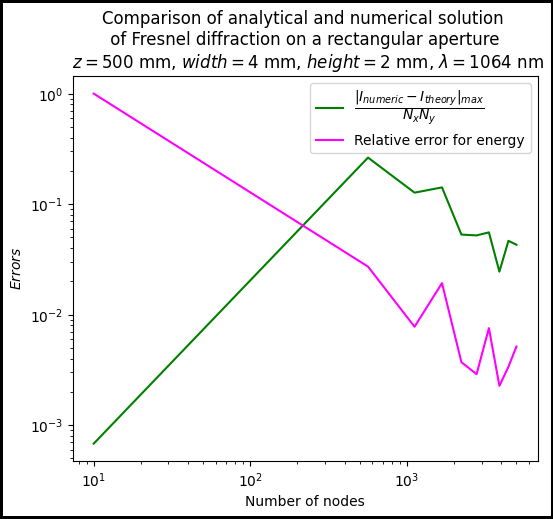

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5), edgecolor='black', linewidth=3,
                       frameon=True)
ax.loglog(nodes_array, error_list, color='green', label=r'$\dfrac{|I_{numeric} - I_{theory}|_{max}}{N_x N_y}$')
ax.loglog(nodes_array, relative_error, color='magenta', label='Relative error for energy')

ax.set_title('Comparison of analytical and numerical solution \n of Fresnel diffraction on a rectangular aperture \n $z=500$ mm, $width=4$ mm, $height=2$ mm, $\lambda=1064$ nm')
ax.set_xlabel('Number of nodes')
ax.set_ylabel(r'$Errors$')
ax.legend()